In [1]:
from pycaret.regression import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split

In [2]:
# data load
df = pd.read_csv('df_trans.csv', encoding='cp949')
df['아파트_단지']=df['아파트_단지'].fillna(0)
df = df.drop('절도', axis=1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('거래금액', axis=1), df['거래금액'], test_size=0.2) # validation dataset separation

In [4]:
df_train = pd.concat([X_train, y_train], axis=1)

In [5]:
reg = setup(
    data = df_train, target='거래금액', session_id=123, 
    transformation=True, normalize=True, numeric_imputation='mode', categorical_imputation='mode',
    remove_multicollinearity=True, multicollinearity_threshold=0.95, 
    ordinal_features={'살인':[1,2,3,4,5], '강도':[1,2,3,4,5], '강간':[1,2,3,4,5], '폭력':[1,2,3,4,5], '방화':[1,2,3,4,5],
    '마약':[1,2,3,4,5], '약취':[1,2,3,4,5], '도박':[1,2,3,4,5]}, categorical_features=['1층유무','용도_판매','용도_제2종근린생활'],
)

,Description,Value
0,Session id,123
1,Target,거래금액
2,Target type,Regression
3,Data shape,"(4186, 33)"
4,Train data shape,"(2930, 33)"
5,Test data shape,"(1256, 33)"
6,Ordinal features,11
7,Numeric features,32
8,Categorical features,3
9,Preprocess,True


In [6]:
compare_models(errors='raise')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2762,0.1558,0.3943,0.8406,0.2021,4.3010,0.0690
xgboost,Extreme Gradient Boosting,0.2750,0.1702,0.4121,0.8260,0.2075,4.6609,0.2970
et,Extra Trees Regressor,0.2756,0.1785,0.4221,0.8169,0.2140,4.6237,0.3330
rf,Random Forest Regressor,0.2965,0.1897,0.4347,0.8056,0.2182,4.5640,0.5610
gbr,Gradient Boosting Regressor,0.3400,0.2084,0.4556,0.7872,0.2328,4.2904,0.3150
ada,AdaBoost Regressor,0.4834,0.3615,0.6006,0.6297,0.2917,5.0799,0.1480
knn,K Neighbors Regressor,0.4350,0.3785,0.6141,0.6120,0.2917,5.3817,0.0190
br,Bayesian Ridge,0.4624,0.3811,0.6165,0.6101,0.2905,6.7707,0.0160
lar,Least Angle Regression,0.4623,0.3812,0.6166,0.6100,0.2903,6.8375,0.0160
ridge,Ridge Regression,0.4623,0.3812,0.6165,0.6100,0.2904,6.8335,0.0140


LGBMRegressor(random_state=123)

In [7]:
lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2787,0.1587,0.3984,0.8215,0.2073,4.0041
1,0.2747,0.1556,0.3945,0.8523,0.2056,2.9737
2,0.2850,0.1528,0.3909,0.8523,0.2100,3.4272
3,0.2600,0.1319,0.3631,0.8585,0.1965,2.4951
4,0.2726,0.1379,0.3713,0.8639,0.1965,2.2102
5,0.2674,0.1509,0.3884,0.8331,0.2057,13.5646
6,0.2749,0.1549,0.3936,0.8200,0.2019,1.9475
7,0.3030,0.1887,0.4344,0.8495,0.2096,1.1315
8,0.2793,0.1706,0.4131,0.8260,0.1979,3.2183


In [ ]:
tuned_lgbm = tune_model(lgbm)

In [9]:
plot_model(tuned_lgbm, plot = 'parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


In [10]:
plot_model(tuned_lgbm, plot = 'error', save=True)

'Prediction Error.png'

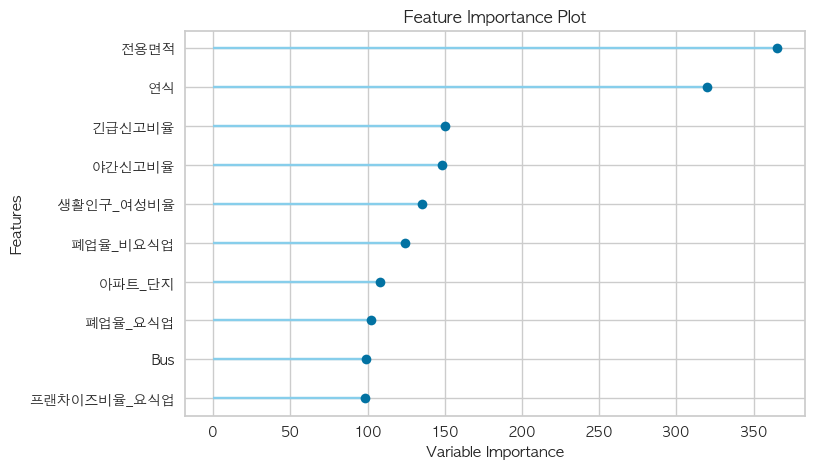

In [11]:
# FeatureImportancePlot
plot_model(tuned_lgbm, plot='feature')

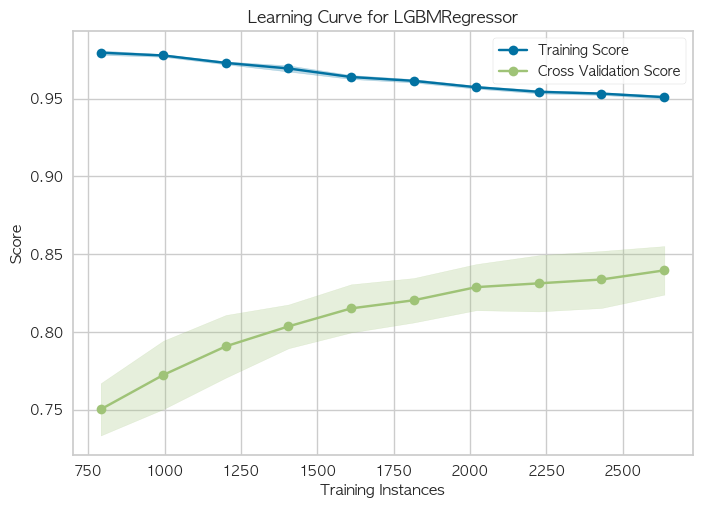

In [12]:
# AUC plot
plot_model(tuned_lgbm, plot='learning')

In [13]:
# Feature Importance as df
featureimportance = pd.DataFrame([tuned_lgbm.feature_name_, tuned_lgbm.feature_importances_]).T
featureimportance.sort_values(by=1, ascending=False)
featureimportance = featureimportance.reset_index(drop=True)
featureimportance.columns = ['Col','featureimportance']
featureimportance.to_csv('featureimportance.csv', index=False)
featureimportance

,Col,featureimportance
0,전용면적,365
1,1층유무,97
2,연식,320
3,용도_제2종근린생활,38
4,용도_판매,14
5,살인,45
6,강도,45
7,강간,24
8,폭력,39
9,방화,41


In [14]:
tuned_lgbm.importance_type

'split'

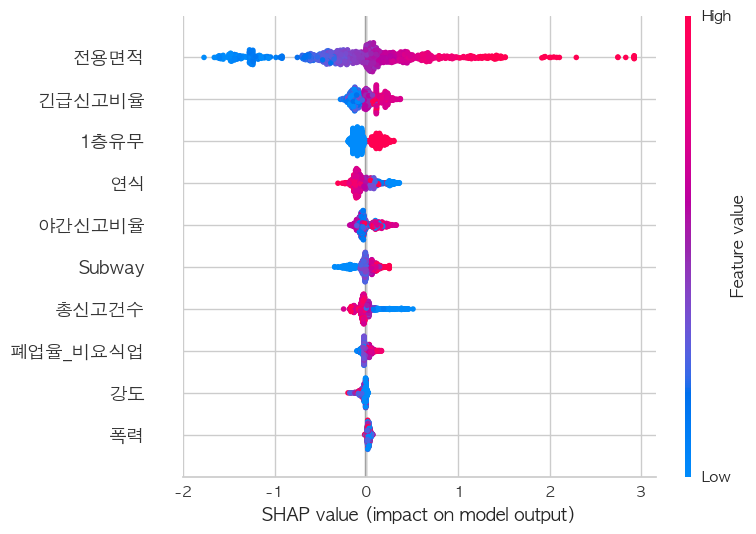

In [17]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(tuned_lgbm)
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test, max_display=10)
plt.show()

In [18]:
from eli5.lightgbm import *
from eli5.sklearn import *
import eli5

perm = PermutationImportance(tuned_lgbm, random_state=42).fit(X_test, y_test)
print(eli5.format_as_text(explain_weights.explain_permutation_importance(perm, feature_names = tuned_lgbm.feature_name_, top=10)))

explain_weights.explain_permutation_importance(perm, feature_names = tuned_lgbm.feature_name_, top=10)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

1.1566 ± 0.0572  전용면적
0.0671 ± 0.0110  긴급신고비율
0.0579 ± 0.0033  1층유무
0.0408 ± 0.0092  연식
0.0324 ± 0.0124  Subway
0.0299 ± 0.0058  야간신고비율
0.0177 ± 0.0099  총신고건수
0.0144 ± 0.0023  Bus
0.0083 ± 0.0042  폐업율_비요식업
0.0079 ± 0.0031  생활인구_여성비율
       … 22 more …        


Weight,Feature
1.1566 ± 0.0572,전용면적
0.0671 ± 0.0110,긴급신고비율
0.0579 ± 0.0033,1층유무
0.0408 ± 0.0092,연식
0.0324 ± 0.0124,Subway
0.0299 ± 0.0058,야간신고비율
0.0177 ± 0.0099,총신고건수
0.0144 ± 0.0023,Bus
0.0083 ± 0.0042,폐업율_비요식업
0.0079 ± 0.0031,생활인구_여성비율
